# Extraction

Reads the three pre-filtered country files:

- `{CC}-areas.geo.jsonseq`
- `{CC}-streets.geo.jsonseq`
- `{CC}-housenums.geo.jsonseq`

And process it as follows:

- Extract only certain properties
- Country border clipping
- For areas: keep only administrative and postal_code boundaries
- For streets: keep only those with a name
- For housenums: compute centroid

The result are 2 "final" tab-separated-values files:

**postal-codes.tsv**

    - postal_code
    - geometry: MultiPolygon

**administrative-areas.tsv**

    - name
    - name:en
    - alt_name
    - geometry: MultiPolygon

And 2 "temporary" tab-separated-values files, to be refined in the next process.

**streets.tsv**

    - name
    - ?name:en
    - ?alt_name
    - geometry: LineString or MultiPolygon

**housenums.tsv**

    - housenumber
    - ?street
    - ?postcode
    - ?city
    - geometry: Point (centroid)


The tags to extract from the full geojson dumps.
They vary strongly from country to country or even within different regions of a country.

The site https://taginfo.openstreetmap.org/tags provides good insight on available tags and their usage.

In [1]:
import os

CC = os.environ.get('CC', 'AD')

AREA_TAGS = [
    'id',
    'boundary',
    'admin_level',
    'postal_code',
    'name',
    'alt_name',
    'name:en',
    'place'
]


STREET_TAGS = [
    'id',
    'highway',
    'name',
    'alt_name',
]

HOUSE_TAGS = [
    'id',
    'addr:housenumber',
    'addr:street',
    'addr:city',
    'addr:postcode'
]

In [2]:
import pandas as pd

admin_level_mapping = pd.read_csv('admin_level_mapping.tsv', sep='\t', dtype={'admin_level':str})
admin_level_mapping = admin_level_mapping[admin_level_mapping['country_code'] == CC]
admin_level_mapping = admin_level_mapping.set_index('admin_level')['area_type']

admin_level_mapping

admin_level
2    country
7       city
Name: area_type, dtype: object

## Country borders

There might be multiple boundaries, for example because of enclaves in neighboring countries or islands beyond territorial waters.

<Axes: >

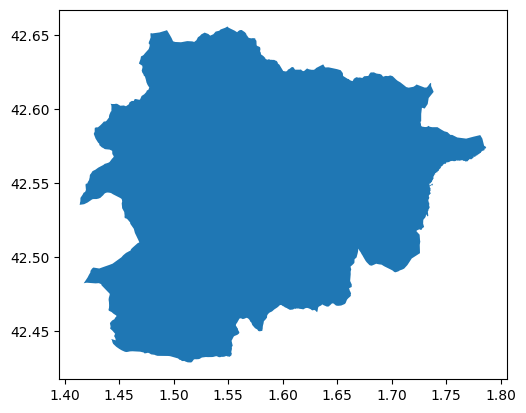

In [3]:
import geopandas as gpd
country_borders = gpd.read_file(f'extracts/{CC}-borders.geojson', engine="pyogrio")
country_borders.plot()

# Areas

In [4]:
areas = gpd.read_file(f'temp/{CC}-areas.geo.jsonseq', encoding="utf8", engine="pyogrio", columns=AREA_TAGS)
areas.rename(columns={'id': 'area_id', 'name': 'area_name'}, inplace=True)
areas


,admin_level,boundary,area_id,area_name,name:en,postal_code,geometry
0,None,national_park,a11523321,Parc Natural de la Vall de Sorteny,None,None,"MULTIPOLYGON (((1.54790 42.62413, 1.55028 42.6..."
1,None,national_park,a11523341,Parc Natural Comunal de les Valls del Comapedrosa,None,None,"MULTIPOLYGON (((1.42661 42.58334, 1.42830 42.5..."
2,7,administrative,a5609511,Encamp,None,AD200,"MULTIPOLYGON (((1.54605 42.52380, 1.54632 42.5..."
3,7,administrative,a5609509,Canillo,None,AD100,"MULTIPOLYGON (((1.56201 42.54629, 1.57938 42.5..."
4,7,administrative,a5609507,Andorra la Vella,None,AD500,"MULTIPOLYGON (((1.46033 42.50447, 1.46618 42.4..."
5,7,administrative,a5609513,Escaldes-Engordany,None,AD700,"MULTIPOLYGON (((1.52156 42.52287, 1.52192 42.5..."
6,7,administrative,a5609519,Sant Julià de Lòria,None,AD600,"MULTIPOLYGON (((1.41739 42.48239, 1.42023 42.4..."
7,2,administrative,a18815,Andorra,Andorra,None,"MULTIPOLYGON (((1.41358 42.53538, 1.41615 42.5..."
8,7,administrative,a5609517,Ordino,None,AD300,"MULTIPOLYGON (((1.46802 42.63089, 1.47110 42.6..."
9,7,administrative,a5609515,La Massana,None,AD400,"MULTIPOLYGON (((1.41358 42.53538, 1.41615 42.5..."


In [5]:
areas['geometry'].type.value_counts()

MultiPolygon    11
Name: count, dtype: int64

<Axes: >

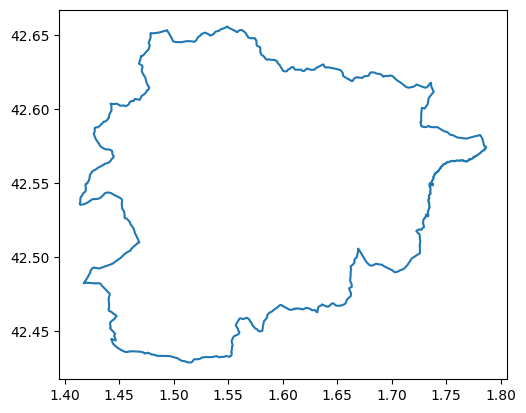

In [6]:
areas[areas['admin_level'] == '2'].boundary.plot()

## Filtering

In [7]:
areas = areas[areas['boundary'].isin(['administrative', 'postal_code'])]
areas

,admin_level,boundary,area_id,area_name,name:en,postal_code,geometry
2,7,administrative,a5609511,Encamp,None,AD200,"MULTIPOLYGON (((1.54605 42.52380, 1.54632 42.5..."
3,7,administrative,a5609509,Canillo,None,AD100,"MULTIPOLYGON (((1.56201 42.54629, 1.57938 42.5..."
4,7,administrative,a5609507,Andorra la Vella,None,AD500,"MULTIPOLYGON (((1.46033 42.50447, 1.46618 42.4..."
5,7,administrative,a5609513,Escaldes-Engordany,None,AD700,"MULTIPOLYGON (((1.52156 42.52287, 1.52192 42.5..."
6,7,administrative,a5609519,Sant Julià de Lòria,None,AD600,"MULTIPOLYGON (((1.41739 42.48239, 1.42023 42.4..."
7,2,administrative,a18815,Andorra,Andorra,None,"MULTIPOLYGON (((1.41358 42.53538, 1.41615 42.5..."
8,7,administrative,a5609517,Ordino,None,AD300,"MULTIPOLYGON (((1.46802 42.63089, 1.47110 42.6..."
9,7,administrative,a5609515,La Massana,None,AD400,"MULTIPOLYGON (((1.41358 42.53538, 1.41615 42.5..."


In [8]:
areas = areas.clip(country_borders)
areas

,admin_level,boundary,area_id,area_name,name:en,postal_code,geometry
6,7,administrative,a5609519,Sant Julià de Lòria,None,AD600,"POLYGON ((1.41739 42.48239, 1.41915 42.48428, ..."
5,7,administrative,a5609513,Escaldes-Engordany,None,AD700,"POLYGON ((1.56085 42.45931, 1.55985 42.46032, ..."
4,7,administrative,a5609507,Andorra la Vella,None,AD500,"POLYGON ((1.47105 42.51096, 1.47268 42.51147, ..."
2,7,administrative,a5609511,Encamp,None,AD200,"POLYGON ((1.66143 42.49228, 1.66036 42.49239, ..."
7,2,administrative,a18815,Andorra,Andorra,None,"POLYGON ((1.41358 42.53538, 1.41388 42.53601, ..."
9,7,administrative,a5609515,La Massana,None,AD400,"POLYGON ((1.41358 42.53538, 1.41388 42.53601, ..."
3,7,administrative,a5609509,Canillo,None,AD100,"POLYGON ((1.71747 42.55706, 1.70278 42.55776, ..."
8,7,administrative,a5609517,Ordino,None,AD300,"POLYGON ((1.46802 42.63089, 1.46946 42.63385, ..."


In [9]:
areas['geometry'].type.value_counts()

Polygon    8
Name: count, dtype: int64

In [10]:
areas = areas[areas['geometry'].type.isin(['Polygon', 'MultiPolygon'])]
areas

,admin_level,boundary,area_id,area_name,name:en,postal_code,geometry
6,7,administrative,a5609519,Sant Julià de Lòria,None,AD600,"POLYGON ((1.41739 42.48239, 1.41915 42.48428, ..."
5,7,administrative,a5609513,Escaldes-Engordany,None,AD700,"POLYGON ((1.56085 42.45931, 1.55985 42.46032, ..."
4,7,administrative,a5609507,Andorra la Vella,None,AD500,"POLYGON ((1.47105 42.51096, 1.47268 42.51147, ..."
2,7,administrative,a5609511,Encamp,None,AD200,"POLYGON ((1.66143 42.49228, 1.66036 42.49239, ..."
7,2,administrative,a18815,Andorra,Andorra,None,"POLYGON ((1.41358 42.53538, 1.41388 42.53601, ..."
9,7,administrative,a5609515,La Massana,None,AD400,"POLYGON ((1.41358 42.53538, 1.41388 42.53601, ..."
3,7,administrative,a5609509,Canillo,None,AD100,"POLYGON ((1.71747 42.55706, 1.70278 42.55776, ..."
8,7,administrative,a5609517,Ordino,None,AD300,"POLYGON ((1.46802 42.63089, 1.46946 42.63385, ..."


In [11]:
# It might be the case that postal codes do not exist in the country
# However, we need that column for later processing, even if it's empty
import numpy as np

if 'postal_code' not in areas.columns:
    areas['postal_code'] = np.nan

In [12]:
# copy() to release memory instead of slice which keeps the original ...does mem release work?
areas = areas.copy()

## Administrative areas

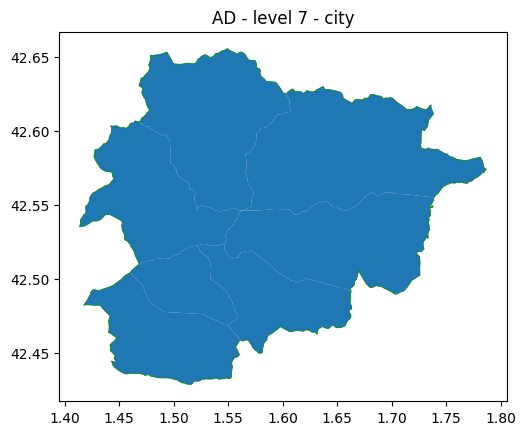

In [13]:
for i in range(3,11):
    level = str(i)
    admin_level = areas[areas['admin_level'] == level]
    if not admin_level.empty:
        area_name = admin_level_mapping.get(level, '??? (ignored)')
        ax = admin_level.plot()
        country_borders.boundary.plot(linewidth=0.5, ax=ax, color='green')
        ax.set_title(f'{CC} - level {i} - {area_name}')

In [14]:
administrative_areas = areas.drop(columns=['boundary', 'postal_code']).dropna(subset='admin_level').sort_values(['admin_level', 'area_name'])
administrative_areas['admin_level'].replace(admin_level_mapping, inplace=True)
administrative_areas.to_csv(f'addresses/{CC}-administrative-areas.tsv.gz', index=False, encoding="utf8", sep='\t')
administrative_areas

,admin_level,area_id,area_name,name:en,geometry
7,country,a18815,Andorra,Andorra,"POLYGON ((1.41358 42.53538, 1.41388 42.53601, ..."
4,city,a5609507,Andorra la Vella,None,"POLYGON ((1.47105 42.51096, 1.47268 42.51147, ..."
3,city,a5609509,Canillo,None,"POLYGON ((1.71747 42.55706, 1.70278 42.55776, ..."
2,city,a5609511,Encamp,None,"POLYGON ((1.66143 42.49228, 1.66036 42.49239, ..."
5,city,a5609513,Escaldes-Engordany,None,"POLYGON ((1.56085 42.45931, 1.55985 42.46032, ..."
9,city,a5609515,La Massana,None,"POLYGON ((1.41358 42.53538, 1.41388 42.53601, ..."
8,city,a5609517,Ordino,None,"POLYGON ((1.46802 42.63089, 1.46946 42.63385, ..."
6,city,a5609519,Sant Julià de Lòria,None,"POLYGON ((1.41739 42.48239, 1.41915 42.48428, ..."


## Postal codes

In [15]:
postal_codes = areas[['area_id', 'postal_code', 'geometry']].dropna().sort_values(['postal_code']).copy()
postal_codes.to_csv(f'addresses/{CC}-postal-codes.tsv.gz', index=False, encoding="utf8", sep='\t')
postal_codes

,area_id,postal_code,geometry
3,a5609509,AD100,"POLYGON ((1.71747 42.55706, 1.70278 42.55776, ..."
2,a5609511,AD200,"POLYGON ((1.66143 42.49228, 1.66036 42.49239, ..."
8,a5609517,AD300,"POLYGON ((1.46802 42.63089, 1.46946 42.63385, ..."
9,a5609515,AD400,"POLYGON ((1.41358 42.53538, 1.41388 42.53601, ..."
4,a5609507,AD500,"POLYGON ((1.47105 42.51096, 1.47268 42.51147, ..."
6,a5609519,AD600,"POLYGON ((1.41739 42.48239, 1.41915 42.48428, ..."
5,a5609513,AD700,"POLYGON ((1.56085 42.45931, 1.55985 42.46032, ..."


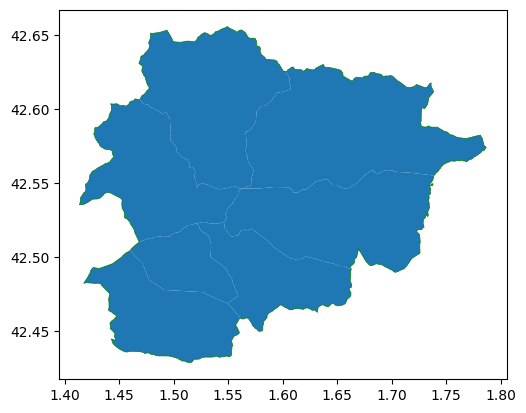

In [16]:
if postal_codes.empty:
    print('No postal code areas in this country!')
else:
    ax = postal_codes.plot()
    country_borders.boundary.plot(linewidth=0.5, ax=ax, color='green')

# Streets

In [17]:
streets = gpd.read_file(f'temp/{CC}-streets.geo.jsonseq', encoding="utf8", engine="pyogrio", columns=STREET_TAGS)
streets.rename(columns={'id': 'street_id', 'name': 'street_name'}, inplace=True)
streets

,alt_name,highway,street_id,street_name,geometry
0,None,primary,w6165717,Avinguda del Consell General,"LINESTRING (1.73396 42.54366, 1.73405 42.54370..."
1,None,primary,w6165764,Avinguda del Consell General,"LINESTRING (1.73357 42.54379, 1.73350 42.54377..."
2,None,primary,w6165766,Avinguda del Consell General,"LINESTRING (1.73214 42.54448, 1.73214 42.54445..."
3,None,trunk,w6176755,Túnel d'Envalira,"LINESTRING (1.69947 42.54678, 1.69986 42.54642..."
4,None,primary,w6179103,Avinguda Coprincep Épiscopal,"LINESTRING (1.55962 42.52194, 1.55987 42.52209..."
...,...,...,...,...,...
1380,None,path,w1132194854,Camí d'Aran,"LINESTRING (1.53709 42.55618, 1.53742 42.55618..."
1381,None,primary,w1135732328,Rotonda de la Juberrussa,"LINESTRING (1.48210 42.44554, 1.48217 42.44559..."
1382,None,footway,w1152728576,Camí dels Vilars,"LINESTRING (1.53985 42.51300, 1.53986 42.51306..."
1383,None,cycleway,w1153959716,Camí lateral,"LINESTRING (1.50381 42.49528, 1.50365 42.49524..."


## Filtering

In [18]:
# 'footway' is included because in "less urbanized" places, there are valid addresses on footways 
HIGHWAY_TYPES = ['trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'living_street', 'service', 'pedestrian', 'track', 'road', 'footway']
streets = streets[streets['highway'].isin(HIGHWAY_TYPES)]
streets

,alt_name,highway,street_id,street_name,geometry
0,None,primary,w6165717,Avinguda del Consell General,"LINESTRING (1.73396 42.54366, 1.73405 42.54370..."
1,None,primary,w6165764,Avinguda del Consell General,"LINESTRING (1.73357 42.54379, 1.73350 42.54377..."
2,None,primary,w6165766,Avinguda del Consell General,"LINESTRING (1.73214 42.54448, 1.73214 42.54445..."
3,None,trunk,w6176755,Túnel d'Envalira,"LINESTRING (1.69947 42.54678, 1.69986 42.54642..."
4,None,primary,w6179103,Avinguda Coprincep Épiscopal,"LINESTRING (1.55962 42.52194, 1.55987 42.52209..."
...,...,...,...,...,...
1373,None,tertiary,w1102353412,Avinguda d'Encamp,"LINESTRING (1.73381 42.54230, 1.73379 42.54225..."
1377,None,footway,w1103539649,Carrer dels Cavallers,"LINESTRING (1.58190 42.53519, 1.58199 42.53517..."
1379,None,service,w1112599509,Carrer dels Pardals,"LINESTRING (1.53389 42.51313, 1.53363 42.51310)"
1381,None,primary,w1135732328,Rotonda de la Juberrussa,"LINESTRING (1.48210 42.44554, 1.48217 42.44559..."


In [19]:
print("Percentage of tags present in raw data")
(1-streets.isna().mean().round(3)) * 100

Percentage of tags present in raw data


alt_name         0.2
highway        100.0
street_id      100.0
street_name    100.0
geometry       100.0
dtype: float64

In [20]:
#streets.dissolve(by='street_name').explode()

In [21]:
# copy() to release memory instead of slice which keeps the original ...does mem release work?
streets = streets.copy()

## Mapping areas to streets

In [22]:
# Using the "centroid" workaround for performance reasons
# See https://github.com/geopandas/geopandas/issues/2840
# Note that the full "way" geometry will be needed later
streets['center'] = streets['geometry'].centroid
streets.set_geometry('center', inplace=True)
streets = streets.clip(country_borders).copy()
streets

/tmp/ipykernel_397944/653104887.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  streets['center'] = streets['geometry'].centroid


,alt_name,highway,street_id,street_name,geometry,center
502,None,track,w189097586,Camí del Conangle al Coll de Pimés,"LINESTRING (1.52614 42.43599, 1.52625 42.43602...",POINT (1.53218 42.43473)
91,None,primary,w6275506,Rotonda Josep Escaler,"LINESTRING (1.53174 42.50613, 1.53170 42.50611...",POINT (1.53178 42.50602)
94,None,residential,w6275512,Carrer Verge del Pilar,"LINESTRING (1.53209 42.50667, 1.53215 42.50662...",POINT (1.53227 42.50643)
429,None,primary,w124672851,Rotonda Km. 0,"LINESTRING (1.53411 42.50648, 1.53413 42.50645...",POINT (1.53427 42.50650)
1009,None,primary,w709529278,Vial de la Uniò,"LINESTRING (1.53419 42.50675, 1.53419 42.50670...",POINT (1.53418 42.50667)
...,...,...,...,...,...,...
419,None,primary,w122383888,Carretera General 3,"LINESTRING (1.51797 42.57803, 1.51811 42.57815...",POINT (1.51896 42.58054)
913,None,primary,w514996689,Carretera General 3,"LINESTRING (1.51940 42.58330, 1.51952 42.58386...",POINT (1.52019 42.58452)
766,None,primary,w351920529,Carretera General 3,"LINESTRING (1.52108 42.58572, 1.52114 42.58587)",POINT (1.52111 42.58579)
1173,None,primary,w997957646,Carretera General 3,"LINESTRING (1.51953 42.63071, 1.51926 42.63079...",POINT (1.51886 42.63090)


In [23]:
from tqdm import tqdm

#streets.set_geometry('geometry', inplace=True) # More complete
streets.set_geometry('center', inplace=True) # Quicker
#streets.drop(columns='index_right', inplace=True)

for admin_level in tqdm(admin_level_mapping.unique()):
    print(admin_level)
    if admin_level == 'country':
        continue
    aa = administrative_areas[administrative_areas['admin_level'] == admin_level][['area_name', 'geometry']]
    aa = aa.rename(columns={'area_name': admin_level})
    streets = streets.sjoin(aa, predicate='intersects', how='left').drop(columns='index_right')

streets

100%|██████████| 2/2 [00:00<00:00, 41.82it/s]

country
city


,alt_name,highway,street_id,street_name,geometry,center,city
502,None,track,w189097586,Camí del Conangle al Coll de Pimés,"LINESTRING (1.52614 42.43599, 1.52625 42.43602...",POINT (1.53218 42.43473),Sant Julià de Lòria
91,None,primary,w6275506,Rotonda Josep Escaler,"LINESTRING (1.53174 42.50613, 1.53170 42.50611...",POINT (1.53178 42.50602),Andorra la Vella
94,None,residential,w6275512,Carrer Verge del Pilar,"LINESTRING (1.53209 42.50667, 1.53215 42.50662...",POINT (1.53227 42.50643),Andorra la Vella
429,None,primary,w124672851,Rotonda Km. 0,"LINESTRING (1.53411 42.50648, 1.53413 42.50645...",POINT (1.53427 42.50650),Escaldes-Engordany
1009,None,primary,w709529278,Vial de la Uniò,"LINESTRING (1.53419 42.50675, 1.53419 42.50670...",POINT (1.53418 42.50667),Andorra la Vella
...,...,...,...,...,...,...,...
419,None,primary,w122383888,Carretera General 3,"LINESTRING (1.51797 42.57803, 1.51811 42.57815...",POINT (1.51896 42.58054),Ordino
913,None,primary,w514996689,Carretera General 3,"LINESTRING (1.51940 42.58330, 1.51952 42.58386...",POINT (1.52019 42.58452),Ordino
766,None,primary,w351920529,Carretera General 3,"LINESTRING (1.52108 42.58572, 1.52114 42.58587)",POINT (1.52111 42.58579),Ordino
1173,None,primary,w997957646,Carretera General 3,"LINESTRING (1.51953 42.63071, 1.51926 42.63079...",POINT (1.51886 42.63090),Ordino


In [24]:
streets = streets.sjoin(postal_codes[['postal_code','geometry']], how='left').drop(columns='index_right')
streets

,alt_name,highway,street_id,street_name,geometry,center,city,postal_code
502,None,track,w189097586,Camí del Conangle al Coll de Pimés,"LINESTRING (1.52614 42.43599, 1.52625 42.43602...",POINT (1.53218 42.43473),Sant Julià de Lòria,AD600
91,None,primary,w6275506,Rotonda Josep Escaler,"LINESTRING (1.53174 42.50613, 1.53170 42.50611...",POINT (1.53178 42.50602),Andorra la Vella,AD500
94,None,residential,w6275512,Carrer Verge del Pilar,"LINESTRING (1.53209 42.50667, 1.53215 42.50662...",POINT (1.53227 42.50643),Andorra la Vella,AD500
429,None,primary,w124672851,Rotonda Km. 0,"LINESTRING (1.53411 42.50648, 1.53413 42.50645...",POINT (1.53427 42.50650),Escaldes-Engordany,AD700
1009,None,primary,w709529278,Vial de la Uniò,"LINESTRING (1.53419 42.50675, 1.53419 42.50670...",POINT (1.53418 42.50667),Andorra la Vella,AD500
...,...,...,...,...,...,...,...,...
419,None,primary,w122383888,Carretera General 3,"LINESTRING (1.51797 42.57803, 1.51811 42.57815...",POINT (1.51896 42.58054),Ordino,AD300
913,None,primary,w514996689,Carretera General 3,"LINESTRING (1.51940 42.58330, 1.51952 42.58386...",POINT (1.52019 42.58452),Ordino,AD300
766,None,primary,w351920529,Carretera General 3,"LINESTRING (1.52108 42.58572, 1.52114 42.58587)",POINT (1.52111 42.58579),Ordino,AD300
1173,None,primary,w997957646,Carretera General 3,"LINESTRING (1.51953 42.63071, 1.51926 42.63079...",POINT (1.51886 42.63090),Ordino,AD300


## Merging multi-section streets

In [25]:
streets.set_geometry('geometry', inplace=True)
streets.drop(columns=['center'], inplace=True)
props = [c for c in streets.columns if c not in STREET_TAGS + ['street_id']]
streets[props]

,street_name,geometry,city,postal_code
502,Camí del Conangle al Coll de Pimés,"LINESTRING (1.52614 42.43599, 1.52625 42.43602...",Sant Julià de Lòria,AD600
91,Rotonda Josep Escaler,"LINESTRING (1.53174 42.50613, 1.53170 42.50611...",Andorra la Vella,AD500
94,Carrer Verge del Pilar,"LINESTRING (1.53209 42.50667, 1.53215 42.50662...",Andorra la Vella,AD500
429,Rotonda Km. 0,"LINESTRING (1.53411 42.50648, 1.53413 42.50645...",Escaldes-Engordany,AD700
1009,Vial de la Uniò,"LINESTRING (1.53419 42.50675, 1.53419 42.50670...",Andorra la Vella,AD500
...,...,...,...,...
419,Carretera General 3,"LINESTRING (1.51797 42.57803, 1.51811 42.57815...",Ordino,AD300
913,Carretera General 3,"LINESTRING (1.51940 42.58330, 1.51952 42.58386...",Ordino,AD300
766,Carretera General 3,"LINESTRING (1.52108 42.58572, 1.52114 42.58587)",Ordino,AD300
1173,Carretera General 3,"LINESTRING (1.51953 42.63071, 1.51926 42.63079...",Ordino,AD300


In [26]:
#def agg(col):
#    return ';'.join(col.unique())
#streets.dissolve(by=['street_name', 'admin_level_7', 'admin_level_8'], aggfunc=agg)


In [27]:
streets['country'] = CC
props = [c for c in admin_level_mapping.unique()] + ['postal_code', 'street_name']
streets_tsv = streets[props].drop_duplicates()
streets_tsv.sort_values(by=list(streets_tsv.columns), inplace=True)
streets_tsv

,country,city,postal_code,street_name
751,AD,Andorra la Vella,AD500,Antic Camí Ral
943,AD,Andorra la Vella,AD500,Antic Carrer Major
29,AD,Andorra la Vella,AD500,Avinguda Consell d'Europa
558,AD,Andorra la Vella,AD500,Avinguda Doctor Mitjavila
506,AD,Andorra la Vella,AD500,Avinguda Meritxell
...,...,...,...,...
927,AD,Sant Julià de Lòria,AD600,avinguda Rocafort
446,AD,Sant Julià de Lòria,AD600,carrer Casa Comuna
85,AD,Sant Julià de Lòria,AD600,carrer de les Escoles
935,AD,Sant Julià de Lòria,AD600,carretera General 1


In [28]:
streets_tsv.to_csv(f'addresses/{CC}-streets.tsv.gz', sep='\t', index=False)
streets_tsv = None

# House numbers

In [29]:
housenums = gpd.read_file(f'temp/{CC}-housenums.geo.jsonseq', encoding="utf8", engine="pyogrio", columns=HOUSE_TAGS)
housenums.rename(columns={'id': 'house_id'}, inplace=True)
#housenums.set_index('house_id', inplace=True)
housenums

,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry
0,La Massana,1,AD400,Avinguda del Ravell,n442881217,POINT (1.51355 42.54760)
1,La Massana,7,AD400,Avinguda el Travès,n442881710,POINT (1.51494 42.54716)
2,Arinsal,16,None,Carretera d'Arinsal,n521143390,POINT (1.48449 42.57174)
3,Arinsal,16,None,Carretera d'Arinsal,n590463653,POINT (1.48429 42.57181)
4,Arinsal,16,None,Carretera d'Arinsal,n590463654,POINT (1.48418 42.57184)
...,...,...,...,...,...,...
266,None,86,None,Carrer Princep Benlloch,a2112311626,"MULTIPOLYGON (((1.51483 42.50523, 1.51497 42.5..."
267,None,73,None,Avinguda Santa Coloma,a2113112448,"MULTIPOLYGON (((1.51031 42.50084, 1.51035 42.5..."
268,Santa Coloma,8-12,AD500,Carrer Mossèn Lluis Pujol,a28195407,"MULTIPOLYGON (((1.50070 42.49740, 1.50071 42.4..."
269,None,10,None,Parc de la Mola,a28239187,"MULTIPOLYGON (((1.53632 42.51167, 1.53636 42.5..."


In [30]:
print("Percentage of tags present in raw data")
(1-housenums.isna().mean().round(3)) * 100

Percentage of tags present in raw data


addr:city            49.8
addr:housenumber    100.0
addr:postcode        51.3
addr:street          96.3
house_id            100.0
geometry            100.0
dtype: float64

In [31]:
housenums['geometry'].type.value_counts()

Point           179
MultiPolygon     91
LineString        1
Name: count, dtype: int64

In [32]:
housenums['geometry'] = housenums['geometry'].centroid
housenums = housenums.clip(country_borders).copy()
housenums

/tmp/ipykernel_397944/660175642.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  housenums['geometry'] = housenums['geometry'].centroid


,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry
134,Juberri,42,AD600,Carrer del Bec,n6698440905,POINT (1.49145 42.43748)
232,Juberri,22,AD600,Carrer de la Geneta,a1216859616,POINT (1.49177 42.43902)
121,Juberri,22,AD600,Carrer de la Geneta,n5764355409,POINT (1.49186 42.43903)
10,Sant Julià de Lòria,s/n,AD600,Carretera d'Espanya,n1922592322,POINT (1.48739 42.45360)
88,Sant Julià de Lòria,50,None,Carretera de Fontaneda,n5141025386,POINT (1.48862 42.46217)
...,...,...,...,...,...,...
234,Soldeu,2,AD100,Carretera General,a1523640344,POINT (1.66390 42.57811)
55,Incles,2,AD100,Carretera General,n3902532114,POINT (1.65975 42.57986)
132,None,75,None,None,n6657130485,POINT (1.66298 42.58345)
155,None,81,None,Carretera de la Vall d'Incles,n8410235617,POINT (1.66446 42.58395)


## Merge house duplicates

Often, house polygons include an additonal house "point".

## Finding missing streets

Finding the nearest street of a house is an *expensive computation*. Therefore, we will work on a *slice* of the dataset having no `addr:street` tag.

In [33]:
street_names = streets[['street_name', 'geometry']]
street_names

,street_name,geometry
502,Camí del Conangle al Coll de Pimés,"LINESTRING (1.52614 42.43599, 1.52625 42.43602..."
91,Rotonda Josep Escaler,"LINESTRING (1.53174 42.50613, 1.53170 42.50611..."
94,Carrer Verge del Pilar,"LINESTRING (1.53209 42.50667, 1.53215 42.50662..."
429,Rotonda Km. 0,"LINESTRING (1.53411 42.50648, 1.53413 42.50645..."
1009,Vial de la Uniò,"LINESTRING (1.53419 42.50675, 1.53419 42.50670..."
...,...,...
419,Carretera General 3,"LINESTRING (1.51797 42.57803, 1.51811 42.57815..."
913,Carretera General 3,"LINESTRING (1.51940 42.58330, 1.51952 42.58386..."
766,Carretera General 3,"LINESTRING (1.52108 42.58572, 1.52114 42.58587)"
1173,Carretera General 3,"LINESTRING (1.51953 42.63071, 1.51926 42.63079..."


In [34]:
street_names.set_geometry('geometry', inplace=True) # More complete

missing_house_streets = housenums[housenums['addr:street'].isna()]
missing_house_streets = missing_house_streets.to_crs(3857).sjoin_nearest(street_names.to_crs(3857), max_distance=100)
missing_house_streets

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry,index_right,street_name
72,None,24,None,None,n4677760389,POINT (167340.279 5235830.370),291,Passatge de Cedre
262,None,2,None,None,a2112295242,POINT (168325.913 5236606.492),481,Carrer Roureda de Sansa
225,La Cortinada,4,AD300,None,a935209334,POINT (169258.867 5246994.611),205,Carretera General 3
239,None,11,None,None,a1531594050,POINT (170563.051 5244350.371),53,Carretera Coll d'Ordino
240,None,9,None,None,a1531594052,POINT (170580.524 5244397.708),53,Carretera Coll d'Ordino
238,None,10,None,None,a1531594048,POINT (170556.182 5244419.449),53,Carretera Coll d'Ordino
237,None,8,None,None,a1531594042,POINT (170569.407 5244460.643),53,Carretera Coll d'Ordino
132,None,75,None,None,n6657130485,POINT (185122.165 5248781.381),101,Carretera de la Vall d'Incles


In [35]:
# List of houses where no street within 100m was found
missing_house_streets[missing_house_streets['street_name'].isna()]

,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry,index_right,street_name


In [36]:
housenums['street'] = housenums['addr:street']
housenums['street'][missing_house_streets.index] = missing_house_streets['street_name']
housenums

/tmp/ipykernel_397944/1868327506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housenums['street'][missing_house_streets.index] = missing_house_streets['street_name']


,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry,street
134,Juberri,42,AD600,Carrer del Bec,n6698440905,POINT (1.49145 42.43748),Carrer del Bec
232,Juberri,22,AD600,Carrer de la Geneta,a1216859616,POINT (1.49177 42.43902),Carrer de la Geneta
121,Juberri,22,AD600,Carrer de la Geneta,n5764355409,POINT (1.49186 42.43903),Carrer de la Geneta
10,Sant Julià de Lòria,s/n,AD600,Carretera d'Espanya,n1922592322,POINT (1.48739 42.45360),Carretera d'Espanya
88,Sant Julià de Lòria,50,None,Carretera de Fontaneda,n5141025386,POINT (1.48862 42.46217),Carretera de Fontaneda
...,...,...,...,...,...,...,...
234,Soldeu,2,AD100,Carretera General,a1523640344,POINT (1.66390 42.57811),Carretera General
55,Incles,2,AD100,Carretera General,n3902532114,POINT (1.65975 42.57986),Carretera General
132,None,75,None,None,n6657130485,POINT (1.66298 42.58345),Carretera de la Vall d'Incles
155,None,81,None,Carretera de la Vall d'Incles,n8410235617,POINT (1.66446 42.58395),Carretera de la Vall d'Incles


## Mapping areas to houses

In [37]:
from tqdm import tqdm

streets.set_geometry('geometry', inplace=True) # More complete

for admin_level in tqdm(administrative_areas['admin_level'].unique()):
    print(admin_level)
    if admin_level == 'country':
        continue
    aa = administrative_areas[administrative_areas['admin_level'] == admin_level][['area_name', 'geometry']]
    aa = aa.rename(columns={'area_name': admin_level})
    housenums = housenums.sjoin(aa, predicate='intersects', how='left').drop(columns='index_right')

housenums

100%|██████████| 2/2 [00:00<00:00, 36.07it/s]

country
city


,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry,street,city
134,Juberri,42,AD600,Carrer del Bec,n6698440905,POINT (1.49145 42.43748),Carrer del Bec,Sant Julià de Lòria
232,Juberri,22,AD600,Carrer de la Geneta,a1216859616,POINT (1.49177 42.43902),Carrer de la Geneta,Sant Julià de Lòria
121,Juberri,22,AD600,Carrer de la Geneta,n5764355409,POINT (1.49186 42.43903),Carrer de la Geneta,Sant Julià de Lòria
10,Sant Julià de Lòria,s/n,AD600,Carretera d'Espanya,n1922592322,POINT (1.48739 42.45360),Carretera d'Espanya,Sant Julià de Lòria
88,Sant Julià de Lòria,50,None,Carretera de Fontaneda,n5141025386,POINT (1.48862 42.46217),Carretera de Fontaneda,Sant Julià de Lòria
...,...,...,...,...,...,...,...,...
234,Soldeu,2,AD100,Carretera General,a1523640344,POINT (1.66390 42.57811),Carretera General,Canillo
55,Incles,2,AD100,Carretera General,n3902532114,POINT (1.65975 42.57986),Carretera General,Canillo
132,None,75,None,None,n6657130485,POINT (1.66298 42.58345),Carretera de la Vall d'Incles,Canillo
155,None,81,None,Carretera de la Vall d'Incles,n8410235617,POINT (1.66446 42.58395),Carretera de la Vall d'Incles,Canillo


In [38]:
housenums = housenums.sjoin(postal_codes[['postal_code','geometry']], how='left').drop(columns='index_right')
housenums

,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry,street,city,postal_code
134,Juberri,42,AD600,Carrer del Bec,n6698440905,POINT (1.49145 42.43748),Carrer del Bec,Sant Julià de Lòria,AD600
232,Juberri,22,AD600,Carrer de la Geneta,a1216859616,POINT (1.49177 42.43902),Carrer de la Geneta,Sant Julià de Lòria,AD600
121,Juberri,22,AD600,Carrer de la Geneta,n5764355409,POINT (1.49186 42.43903),Carrer de la Geneta,Sant Julià de Lòria,AD600
10,Sant Julià de Lòria,s/n,AD600,Carretera d'Espanya,n1922592322,POINT (1.48739 42.45360),Carretera d'Espanya,Sant Julià de Lòria,AD600
88,Sant Julià de Lòria,50,None,Carretera de Fontaneda,n5141025386,POINT (1.48862 42.46217),Carretera de Fontaneda,Sant Julià de Lòria,AD600
...,...,...,...,...,...,...,...,...,...
234,Soldeu,2,AD100,Carretera General,a1523640344,POINT (1.66390 42.57811),Carretera General,Canillo,AD100
55,Incles,2,AD100,Carretera General,n3902532114,POINT (1.65975 42.57986),Carretera General,Canillo,AD100
132,None,75,None,None,n6657130485,POINT (1.66298 42.58345),Carretera de la Vall d'Incles,Canillo,AD100
155,None,81,None,Carretera de la Vall d'Incles,n8410235617,POINT (1.66446 42.58395),Carretera de la Vall d'Incles,Canillo,AD100


In [39]:
print("Percentage of tags present in raw data")
(1-housenums.isna().mean().round(3)) * 100

Percentage of tags present in raw data


addr:city            49.8
addr:housenumber    100.0
addr:postcode        51.3
addr:street          96.3
house_id            100.0
geometry            100.0
street               99.3
city                100.0
postal_code         100.0
dtype: float64

In [40]:
housenums.dropna(subset=['street'], inplace=True)
housenums['x'] = housenums['geometry'].x
housenums['y'] = housenums['geometry'].y
housenums

,addr:city,addr:housenumber,addr:postcode,addr:street,house_id,geometry,street,city,postal_code,x,y
134,Juberri,42,AD600,Carrer del Bec,n6698440905,POINT (1.49145 42.43748),Carrer del Bec,Sant Julià de Lòria,AD600,1.491445,42.437477
232,Juberri,22,AD600,Carrer de la Geneta,a1216859616,POINT (1.49177 42.43902),Carrer de la Geneta,Sant Julià de Lòria,AD600,1.491768,42.439016
121,Juberri,22,AD600,Carrer de la Geneta,n5764355409,POINT (1.49186 42.43903),Carrer de la Geneta,Sant Julià de Lòria,AD600,1.491861,42.439031
10,Sant Julià de Lòria,s/n,AD600,Carretera d'Espanya,n1922592322,POINT (1.48739 42.45360),Carretera d'Espanya,Sant Julià de Lòria,AD600,1.487385,42.453601
88,Sant Julià de Lòria,50,None,Carretera de Fontaneda,n5141025386,POINT (1.48862 42.46217),Carretera de Fontaneda,Sant Julià de Lòria,AD600,1.488621,42.462165
...,...,...,...,...,...,...,...,...,...,...,...
234,Soldeu,2,AD100,Carretera General,a1523640344,POINT (1.66390 42.57811),Carretera General,Canillo,AD100,1.663895,42.578106
55,Incles,2,AD100,Carretera General,n3902532114,POINT (1.65975 42.57986),Carretera General,Canillo,AD100,1.659746,42.579856
132,None,75,None,None,n6657130485,POINT (1.66298 42.58345),Carretera de la Vall d'Incles,Canillo,AD100,1.662981,42.583445
155,None,81,None,Carretera de la Vall d'Incles,n8410235617,POINT (1.66446 42.58395),Carretera de la Vall d'Incles,Canillo,AD100,1.664458,42.583948


In [41]:
housenums['house_number'] = housenums['addr:housenumber']
housenums['city'] = housenums['city'].combine_first(housenums['addr:city'])
housenums['postal_code'] = housenums['postal_code'].combine_first(housenums['addr:postcode'])

In [42]:
housenums_tsv = housenums[['postal_code', 'city', 'street', 'house_number', 'x', 'y']].drop_duplicates()
housenums_tsv.sort_values(by=list(housenums_tsv.columns), inplace=True)
housenums_tsv['country'] = CC
housenums_tsv

,postal_code,city,street,house_number,x,y,country
136,AD100,Canillo,Av. Sant Joan de Caselles,15,1.598758,42.566201,AD
105,AD100,Canillo,CG-2,km. 22,1.685750,42.559508,AD
235,AD100,Canillo,Camí del Port Dret,12,1.666192,42.578082,AD
55,AD100,Canillo,Carretera General,2,1.659746,42.579856,AD
234,AD100,Canillo,Carretera General,2,1.663895,42.578106,AD
...,...,...,...,...,...,...,...
17,AD700,Escaldes-Engordany,Parc de la Mola,6,1.539118,42.510881,AD
253,AD700,Escaldes-Engordany,Plaça Coprínceps,2,1.539898,42.508945,AD
252,AD700,Escaldes-Engordany,Plaça Coprínceps,4,1.539789,42.509203,AD
251,AD700,Escaldes-Engordany,Plaça Coprínceps,5,1.539442,42.509337,AD


In [43]:
housenums_tsv.to_csv(f'addresses/{CC}-houses.tsv.gz', sep='\t', index=False)
! echo {len(housenums_tsv)} > temp/{CC}-houses-count.txt
#housenums_tsv = None

# Addresses

In this case, the houses are "merged" into streets with house numbers.
Unlike the "streets" approach, it results in a more fine grained dataset.

- it includes only streets with at least a single house (number)
- it differentiates between street sections with house number ranges belonging to different administrative areas or postal codes
- it differentiates between different sides of the street (with odd/even house numbers) belonging to different administrative areas or postal codes
- it has boundaries

In [69]:
def concat(house_number):
    nums_list = [num for num in house_number if num.isdecimal()]
    if nums_list == []:
        return None
    return ';'.join(nums_list)
                    
def minMaxOddEven(house_number_concat):
    nums = [int(num) for num in house_number_concat.split(';')]
    odd = True if len(nums) <= 1 else any(x % 2 == 1 for x in nums)
    even = True if len(nums) <= 1 else any(x % 2 == 0 for x in nums)
    return (min(nums), max(nums), odd, even)

addresses = housenums_tsv.groupby(['postal_code', 'city', 'street'])
addresses = addresses.agg({'x':['min', 'max'], 'y':['min','max'], 'house_number': concat}).reset_index()#.reset_index()
addresses.columns = ['_'.join(col) for col in addresses.columns]
addresses.dropna(subset='house_number_concat', inplace=True)
addresses[['house_min', 'house_max', 'house_odd', 'house_even']] = addresses['house_number_concat'].apply(minMaxOddEven).apply(pd.Series)
addresses.drop(columns=['house_number_concat'], inplace=True)
addresses




,postal_code_,city_,street_,x_min,x_max,y_min,y_max,house_min,house_max,house_odd,house_even
0,AD100,Canillo,Av. Sant Joan de Caselles,1.598758,1.598758,42.566201,42.566201,15,15,True,True
2,AD100,Canillo,Camí del Port Dret,1.666192,1.666192,42.578082,42.578082,12,12,True,True
3,AD100,Canillo,Carretera General,1.659746,1.666080,42.576896,42.579856,2,36,False,True
4,AD100,Canillo,Carretera de la Vall d'Incles,1.662981,1.664458,42.583445,42.583948,75,81,True,False
5,AD100,Canillo,Ctra. de Ransol,1.637147,1.637147,42.584457,42.584457,5,5,True,True
...,...,...,...,...,...,...,...,...,...,...,...
112,AD700,Escaldes-Engordany,Carrer dels Escalls,1.534671,1.534671,42.512075,42.512075,13,13,True,True
113,AD700,Escaldes-Engordany,Carretera d'Engolasters,1.549302,1.549302,42.511535,42.511535,3,3,True,True
114,AD700,Escaldes-Engordany,Isabel Sandy,1.536496,1.536496,42.508202,42.508202,3,3,True,True
115,AD700,Escaldes-Engordany,Parc de la Mola,1.537329,1.539118,42.510778,42.511521,6,10,False,True


In [ ]:
addresses.to_csv(f'addresses/{CC}-addresses.tsv.gz', sep='\t', index=False)
! echo {len(addresses)} > temp/{CC}-addresses-count.txt

# Maps

In [45]:
#map = streets[['street_name', 'geometry']].explore(tiles="CartoDB positron", prefer_canvas=True, name="streets", max_zoom=10)
#map = housenums[['house_number', 'geometry']].explore(m=map, color='purple')
#map.save(f'addresses/{CC}-map.html')
#map